In [2]:
from ultralytics import YOLO
import numpy as np
import csv
import cv2
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import cv2
import numpy as np
import csv
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
from collections import defaultdict

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker with tuned parameters
tracker = DeepSort(max_age=5, n_init=3, max_cosine_distance=0.5)

# Load video
cap = cv2.VideoCapture('FeMe-MaMos-MaMe-d2-5ng.MOV')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)      
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store previous positions of tracked objects
previous_positions = defaultdict(lambda: None)

# Store tracking data for CSV export
tracking_data = []

def update_object_history(track_id, position):
    """Update the history of the tracked object's positions."""
    if previous_positions[track_id] is None:
        previous_positions[track_id] = [position]
    else:
        previous_positions[track_id].append(position)
        # Limit the size of the history
        if len(previous_positions[track_id]) > 10:
            previous_positions[track_id].pop(0)

def get_most_recent_position(track_id):
    """Retrieve the most recent position of the tracked object."""
    if previous_positions[track_id]:
        return previous_positions[track_id][-1]
    return None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = [[box[:4].cpu().numpy(), box[4].item()] for box in detections]

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate velocity if we have previous position
            previous_position = get_most_recent_position(track_id)
            if previous_position is not None:
                displacement = np.linalg.norm(current_position - previous_position)
                velocity = displacement * fps
            else:
                velocity = 0

            # Update object history
            update_object_history(track_id, current_position)

            # Draw bounding box and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocity:.2f} px/s', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, velocity])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('FeMe-MaMos-MaMe-d2-5ng_MOV.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (px/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 13 fishs, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 23.5ms
Speed: 1.0ms preprocess, 23.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 fishs, 24.1ms
Speed: 1.0ms preprocess, 24.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 fishs, 26.0ms
Speed: 1.0ms preprocess, 26.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 21.5ms
Speed: 1.0ms preprocess, 21.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 28.1ms
Speed: 1.0ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 25.5ms
Speed: 1.0ms preprocess, 25.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 20.0ms
Speed: 1.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 38

In [1]:
import csv
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2
import numpy as np

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')
model.to('cuda')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
# cap = cv2.VideoCapture('0822.mp4')
cap = cv2.VideoCapture('0822.mp4')


# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions of tracked objects
previous_positions = {}

# Store tracking data for CSV export
tracking_data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement = np.linalg.norm(current_position - previous_position)  # Euclidean distance
                velocity = displacement * fps  # pixels per second
            else:
                velocity = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocity:.2f} px/s', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, velocity])

    # Write the frame to the output video file
    out.write(frame)
    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('MOV.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (px/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 70.4ms
Speed: 4.5ms preprocess, 70.4ms inference, 212.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384

PermissionError: [Errno 13] Permission denied: 'MOV.csv'

In [10]:
real_world_distance_m = 3.0  # meters (e.g., known width of an object or distance)
pixel_distance_px = 600.0    # pixels (corresponding pixel width in the video)
scale_m_per_px = real_world_distance_m / pixel_distance_px 

In [12]:

(1327.00267672265 -1326.2885784183827)**2 + (578.6058920309875-579.8959863945496)**2

np.sqrt(2.174279855051972)*scale_m_per_px *100


0.737271974079439

In [4]:
import csv
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions, total distances, and velocities of tracked objects
previous_positions = {}
total_distances = {}
velocities = {}

# Store tracking data for CSV export
tracking_data = []

# Scale factor (example values)
scale_m_per_px = 0.05  # Example: 0.05 meters per pixel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate displacement and velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement_px = np.linalg.norm(current_position - previous_position)  # Euclidean distance in pixels
                displacement_m = displacement_px * scale_m_per_px  # Convert to meters

                # Calculate velocity (m/s)
                velocity = displacement_m * fps

                # Update total distance
                if track_id in total_distances:
                    total_distances[track_id] += displacement_m
                else:
                    total_distances[track_id] = displacement_m
                
                # Update velocity
                velocities[track_id] = velocity
            else:
                total_distances[track_id] = 0
                velocities[track_id] = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box, distance, and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Dist: {total_distances[track_id]:.2f} m', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocities[track_id]:.2f} m/s', (int(bbox[0]), int(bbox[1])-60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, total_distances[track_id], velocities[track_id]])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking, Distance, and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('tracking_data.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Total Distance (m)', 'Velocity (m/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 57.2ms
Speed: 2.5ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 45.1ms
Speed: 3.5ms preprocess, 45.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 44.1ms
Speed: 3.0ms preprocess, 44.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 43.7ms
Speed: 4.1ms preprocess, 43.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 24.0ms
Speed: 2.5ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384,

In [17]:
0.07372719740794391/((141-3))

0.000534255053680753

In [8]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'  # Replace with the correct path to your CSV file
data = pd.read_csv(file_path)

# Remove the 'Velocity (m/s)' column
if 'Velocity (px/s)' in data.columns:
    data = data.drop(columns=['Velocity (px/s)'])
    

# Save the updated CSV file
output_file_path = 'tracking_data_updated_2.csv'
data.to_csv(output_file_path, index=False)

print(f"Updated file saved to {output_file_path}")


Updated file saved to tracking_data_updated_2.csv


In [9]:
data

Frame  Object ID     X Center     Y Center
0           3.0          1   985.757581   412.531001
1           3.0          2  1147.786982   700.017559
2           3.0          3  1712.668620   464.779109
3           3.0          4  1061.017748   667.362990
4           3.0          5  1644.126933   718.161430
...         ...        ...          ...          ...
203869  18090.0       3881  1289.135880  1075.748135
203870  18090.0       3887  1813.568151   359.366298
203871  18090.0       3892  1050.726368   851.547256
203872  18090.0       3893  2283.407856   771.872444
203873  18090.0       3894  1242.460895  1019.585683

[203874 rows x 4 columns]

In [10]:
import pandas as pd
import numpy as np

# Load the data (assuming the data is in a CSV file)
data = pd.read_csv('tracking_data_updated_2.csv')

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Initialize an empty DataFrame for results
velocity_data = pd.DataFrame(columns=['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity'])

# Calculate velocities for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id].copy()
    
    # Calculate differences in X and Y coordinates between consecutive frames
    obj_data['X_diff'] = obj_data['X Center'].diff().fillna(0)
    obj_data['Y_diff'] = obj_data['Y Center'].diff().fillna(0)
    
    # Calculate the Euclidean distance (velocity) between frames
    obj_data['Velocity'] = np.sqrt(obj_data['X_diff']**2 + obj_data['Y_diff']**2)*((141-3)/4)*0.01
    
    # Append the results to the velocity_data DataFrame
    velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity']]])
    

# Group by object ID and check if velocities are different
def check_velocity_variation(group):
    velocities = group['Velocity'].values
    return len(set(velocities)) > 1

# Check each object ID for varying velocities
velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)

# Filter object IDs with varying velocities
objects_with_varying_velocities = velocity_variation[velocity_variation].index

print("Object IDs with varying velocities:")
print(objects_with_varying_velocities.tolist())

# Optional: Save the filtered results to a CSV file
velocity_data.to_csv('velocity_per_frame_new.csv', index=False)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\3395112386.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity']]])
C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\3395112386.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)


Object IDs with varying velocities:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 20, 23, 24, 25, 30, 35, 38, 41, 42, 43, 44, 47, 48, 53, 61, 62, 65, 67, 68, 73, 76, 79, 81, 85, 91, 93, 94, 97, 98, 101, 103, 105, 110, 114, 117, 119, 120, 122, 123, 124, 131, 132, 137, 138, 139, 141, 145, 146, 150, 152, 155, 156, 158, 161, 163, 164, 172, 173, 176, 177, 180, 181, 182, 186, 190, 195, 196, 199, 201, 206, 207, 214, 216, 222, 223, 234, 240, 242, 243, 256, 258, 264, 268, 269, 273, 274, 277, 280, 282, 286, 287, 289, 292, 293, 296, 297, 298, 303, 305, 306, 312, 314, 316, 317, 322, 323, 327, 329, 332, 333, 338, 340, 343, 345, 347, 348, 349, 354, 355, 356, 357, 358, 359, 363, 364, 365, 368, 375, 377, 378, 379, 380, 383, 384, 385, 386, 387, 388, 391, 398, 404, 405, 409, 410, 411, 412, 413, 414, 415, 416, 418, 419, 420, 427, 429, 430, 438, 445, 447, 456, 460, 463, 467, 471, 474, 476, 481, 486, 492, 497, 498, 499, 506, 507, 511, 513, 522, 523, 524, 528, 529, 532, 535, 537, 541, 542, 546, 550, 551,

In [35]:
1/((141-3)/4)

0.028985507246376812

In [11]:
import pandas as pd
import numpy as np

# Load the data (assuming the data is in a CSV file)
data = pd.read_csv('tracking_data_updated_2.csv')

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Initialize an empty DataFrame for results
velocity_data = pd.DataFrame(columns=['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part'])

# Define x-coordinate ranges for the three parts
x1 = 719.091584
x2 = 1176.909120

# Calculate velocities for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id].copy()
    
    # Calculate differences in X and Y coordinates between consecutive frames
    obj_data['X_diff'] = obj_data['X Center'].diff().fillna(0)
    obj_data['Y_diff'] = obj_data['Y Center'].diff().fillna(0)
    
    # Calculate the Euclidean distance (velocity) between frames
    obj_data['Velocity'] = np.sqrt(obj_data['X_diff']**2 + obj_data['Y_diff']**2)*((141-3)/4)*0.01
    
    # Determine the part for each x-coordinate
    obj_data['Part'] = pd.cut(obj_data['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[0, 1, 2])

    # Append the results to the velocity_data DataFrame
    velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])

# Group by object ID and check if velocities are different
def check_velocity_variation(group):
    velocities = group['Velocity'].values
    return len(set(velocities)) > 1

# Check each object ID for varying velocities
velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)

# Filter object IDs with varying velocities
objects_with_varying_velocities = velocity_variation[velocity_variation].index

print("Object IDs with varying velocities:")
print(objects_with_varying_velocities.tolist())

# Optional: Save the filtered results to a CSV file
velocity_data.to_csv('velocity_per_frame_filtered.csv', index=False)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\716982141.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])
C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\716982141.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])
C:\Users\MAY02\AppData\Local\Tem

Object IDs with varying velocities:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 20, 23, 24, 25, 30, 35, 38, 41, 42, 43, 44, 47, 48, 53, 61, 62, 65, 67, 68, 73, 76, 79, 81, 85, 91, 93, 94, 97, 98, 101, 103, 105, 110, 114, 117, 119, 120, 122, 123, 124, 131, 132, 137, 138, 139, 141, 145, 146, 150, 152, 155, 156, 158, 161, 163, 164, 172, 173, 176, 177, 180, 181, 182, 186, 190, 195, 196, 199, 201, 206, 207, 214, 216, 222, 223, 234, 240, 242, 243, 256, 258, 264, 268, 269, 273, 274, 277, 280, 282, 286, 287, 289, 292, 293, 296, 297, 298, 303, 305, 306, 312, 314, 316, 317, 322, 323, 327, 329, 332, 333, 338, 340, 343, 345, 347, 348, 349, 354, 355, 356, 357, 358, 359, 363, 364, 365, 368, 375, 377, 378, 379, 380, 383, 384, 385, 386, 387, 388, 391, 398, 404, 405, 409, 410, 411, 412, 413, 414, 415, 416, 418, 419, 420, 427, 429, 430, 438, 445, 447, 456, 460, 463, 467, 471, 474, 476, 481, 486, 492, 497, 498, 499, 506, 507, 511, 513, 522, 523, 524, 528, 529, 532, 535, 537, 541, 542, 546, 550, 551,

In [4]:
data = pd.read_csv('velocity_per_frame_new.csv')


In [4]:
np.sqrt((1327.00267672265-1326.2885784183827)**2+ (579.8959863945496 -578.6058920309875)**2)

1.474543948158878

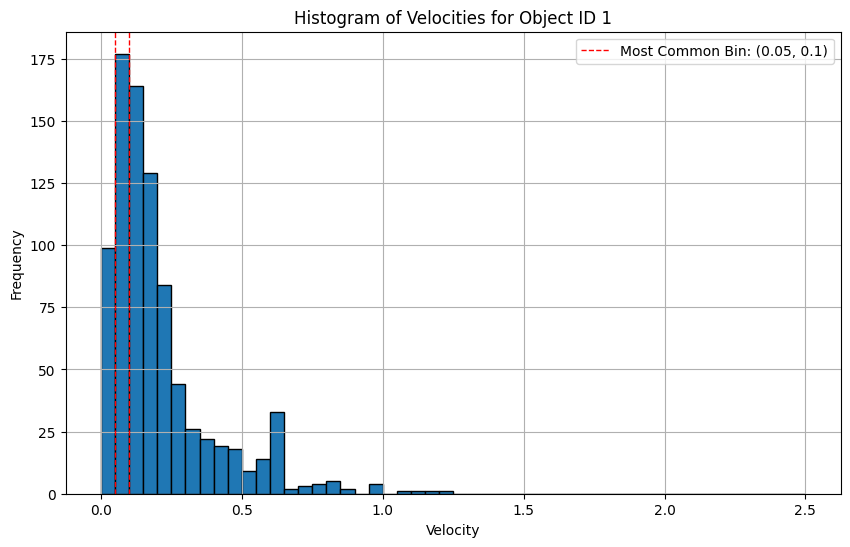

The most common velocity bin range is: (0.05, 0.1)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data in a pandas DataFrame named 'data'
# data = pd.read_csv('your_data_file.csv')  # Load your data file

# Filter data for Object ID 1
obj_data = data[data['Object ID'] == 1]

# Compute histogram data
counts, bin_edges = np.histogram(obj_data['Velocity'], bins=50, range=(0, 2.5))

# Find the bin with the highest count
max_count_index = np.argmax(counts)
most_common_bin_left = bin_edges[max_count_index]
most_common_bin_right = bin_edges[max_count_index + 1]
most_common_bin_range = (most_common_bin_left, most_common_bin_right)

# Plot histogram of velocities
plt.figure(figsize=(10, 6))
plt.hist(obj_data['Velocity'], bins=50, edgecolor='black', range=(0, 2.5))
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Velocities for Object ID 1')

# Highlight the bin with the highest count
plt.axvline(most_common_bin_left, color='r', linestyle='dashed', linewidth=1, label=f'Most Common Bin: {most_common_bin_range}')
plt.axvline(most_common_bin_right, color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.grid(True)
plt.show()

# Print the most common bin range
print(f'The most common velocity bin range is: {most_common_bin_range}')


In [15]:
obj_data['Velocity'].mean()

0.20848674224551397

In [19]:
import pandas as pd

# Load your data
data = pd.read_csv('velocity_per_frame_new.csv')

# Create a list to collect average velocity data
average_velocity_list = []

# Calculate average velocity for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id]
    
    # Calculate the average velocity
    average_velocity = obj_data['Velocity'].mean()
    
    # Append the result to the list
    average_velocity_list.append({
        'Object ID': object_id,
        'Average_Velocity': average_velocity
    })

# Convert the list to a DataFrame
average_velocity_data = pd.DataFrame(average_velocity_list)

# Save the results to a CSV file if needed
average_velocity_data.to_csv('average_velocity_per_object.csv', index=False)

print(average_velocity_data)


      Object ID  Average_Velocity
0             1          0.208487
1             2          0.340067
2             3          0.466039
3             4          0.433807
4             5          0.545589
...         ...               ...
2412       4551          0.291824
2413       4552          0.445259
2414       4555          0.337741
2415       4558          0.718076
2416       4559          0.068688

[2417 rows x 2 columns]


In [22]:
139/4

34.75

In [39]:
obj_data = data[data['Object ID'] == 25]
obj_data

Empty DataFrame
Columns: [Frame, Object ID, X Center, Y Center, Velocity]
Index: []

In [43]:
import csv
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions, total distances, and velocities of tracked objects
previous_positions = {}
total_distances = {}
velocities = {}

# Store tracking data for CSV export
tracking_data = []

# Scale factor (example values)
scale_m_per_px = 0.05  # Example: 0.05 meters per pixel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate displacement and velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement_px = np.linalg.norm(current_position - previous_position)  # Euclidean distance in pixels
                displacement_m = displacement_px * scale_m_per_px  # Convert to meters

                # Calculate velocity (m/s)
                velocity = displacement_m * fps

                # Update total distance
                if track_id in total_distances:
                    total_distances[track_id] += displacement_m
                else:
                    total_distances[track_id] = displacement_m
                
                # Update velocity
                velocities[track_id] = velocity
            else:
                total_distances[track_id] = 0
                velocities[track_id] = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box, distance, and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Dist: {total_distances[track_id]:.2f} m', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocities[track_id]:.2f} m/s', (int(bbox[0]), int(bbox[1])-60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, total_distances[track_id], velocities[track_id]])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking, Distance, and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('tracking_data_strongsort.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Total Distance (m)', 'Velocity (m/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 32.2ms
Speed: 4.0ms preprocess, 32.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 3.5ms
Speed: 2.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


In [44]:
data_1 = pd.read_csv('tracking_data_1fps.csv')


In [47]:
len(data_1['Frame'].unique())

119

In [ ]:
Frame,Object ID,X Center,Y Center,Velocity (px/s)
,1,,0
,2,1147.7869824778165,700.0175593926401,0
,3,1712.6686200328925,464.77910930831104,0
,4,1061.0177483027112,667.3629895904533,0
,5,1644.1269325397825,718.1614298309769,0
,6,,0
,7,1820.8481691848776,589.5574613417806,0
,9,1059.306119473506,813.2237644926882,0
,10,1329.0023371490204,363.0184252116694,0
,11,1053.3087500043562,859.9028235066951,0
,12,1140.528006571818,427.7909226060464,0


In [ ]:
Min 985.757581056713,412.53100108609385

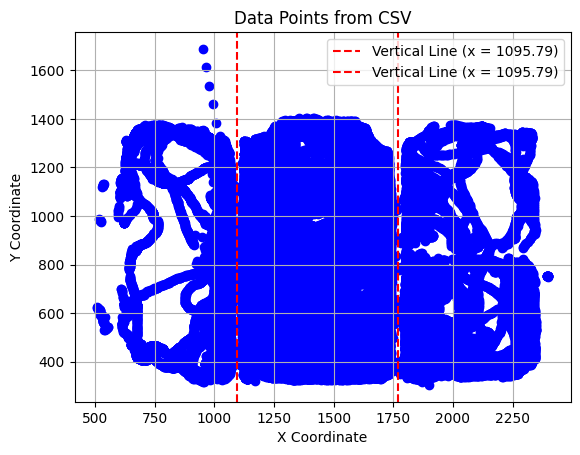

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
df = pd.read_csv('FeMe-MaMos-MaMe-d2-5ng_MOV.csv')

# Assuming the CSV file has columns named 'X Center' and 'Y Center'
x_center = df['X Center']
y_center = df['Y Center']

# Plot the data points
plt.scatter(x_center, y_center, color='blue')

# Draw a vertical line parallel to the y-axis at x = 985.757581056713
x_line = 1095.7869824778165
plt.axvline(x=x_line, color='red', linestyle='--', label='Vertical Line (x = {:.2f})'.format(x_line))
x_line2 = 1770.7869824778165
plt.axvline(x=x_line2, color='red', linestyle='--', label='Vertical Line (x = {:.2f})'.format(x_line))
# Set labels for the axes
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Set title for the plot
plt.title('Data Points from CSV')

# Optionally, add a legend
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()


In [10]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Save the modified DataFrame back to a CSV file
output_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV_with_parts.csv'
df.to_csv(output_path, index=False)

output_path


'FeMe-MaMos-MaMe-d2-5ng_MOV_with_parts.csv'

In [11]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Conversion factor from px/s to m/s (replace with the correct value)
px_to_m = 0.001  # Example: 1 pixel = 0.001 meters

# Convert the 'Velocity (px/s)' column from px/s to m/s
df['Velocity (m/s)'] = df['Velocity (px/s)'] * px_to_m

# Calculate the average velocity for each object in m/s
average_velocity = df.groupby('Object ID')['Velocity (m/s)'].mean().reset_index()

# Merge the average velocity back into the main DataFrame
df = df.merge(average_velocity, on='Object ID', how='left', suffixes=('', '_avg'))

# Calculate the average of the average velocities for each part in m/s
average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()

# Rename columns for clarity
average_velocity_per_part.columns = ['part', 'average_of_average_velocity_m/s']

# Save the result to a CSV file
output_path = 'average_of_average_velocity_per_part_m_s.csv'
average_velocity_per_part.to_csv(output_path, index=False)

output_path


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\761634995.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()


'average_of_average_velocity_per_part_m_s.csv'

In [13]:
df = pd.read_csv('FeMe-MaMos-MaMe-d2-5ng_MOV.csv')
df


Frame  Object ID     X Center     Y Center  Velocity (px/s)
0           3.0          1   985.757581   412.531001         0.000000
1           3.0          2  1147.786982   700.017559         0.000000
2           3.0          3  1712.668620   464.779109         0.000000
3           3.0          4  1061.017748   667.362990         0.000000
4           3.0          5  1644.126933   718.161430         0.000000
...         ...        ...          ...          ...              ...
203869  18090.0       3881  1289.135880  1075.748135        65.638723
203870  18090.0       3887  1813.568151   359.366298        47.106075
203871  18090.0       3892  1050.726368   851.547256         5.327850
203872  18090.0       3893  2283.407856   771.872444       152.969080
203873  18090.0       3894  1242.460895  1019.585683       175.720507

[203874 rows x 5 columns]

C:\Users\MAY02\AppData\Local\Temp\ipykernel_2244\1010666806.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


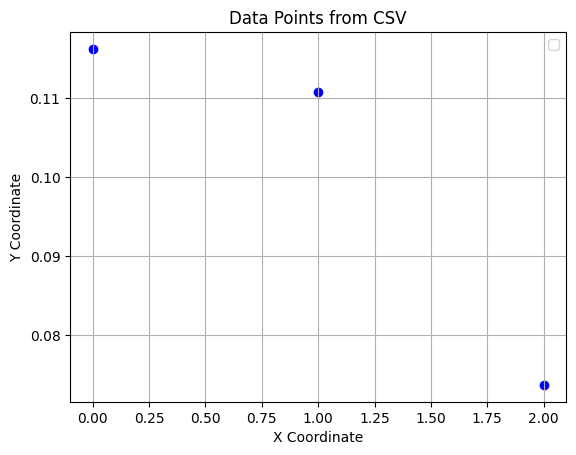

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
df = pd.read_csv('average_of_average_velocity_per_part_m_s.csv')

# Assuming the CSV file has columns named 'X Center' and 'Y Center'
p = df['part']
v = df['average_of_average_velocity_m/s']

# Plot the data points
plt.scatter(p, v, color='blue')

# Set labels for the axes
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Set title for the plot
plt.title('Data Points from CSV')

# Optionally, add a legend
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()


In [21]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)




In [22]:
df

Frame  Object ID     X Center     Y Center  Velocity (px/s)
0           3.0          1   985.757581   412.531001         0.000000
1           3.0          2  1147.786982   700.017559         0.000000
2           3.0          3  1712.668620   464.779109         0.000000
3           3.0          4  1061.017748   667.362990         0.000000
4           3.0          5  1644.126933   718.161430         0.000000
...         ...        ...          ...          ...              ...
203869  18090.0       3881  1289.135880  1075.748135        65.638723
203870  18090.0       3887  1813.568151   359.366298        47.106075
203871  18090.0       3892  1050.726368   851.547256         5.327850
203872  18090.0       3893  2283.407856   771.872444       152.969080
203873  18090.0       3894  1242.460895  1019.585683       175.720507

[203874 rows x 5 columns]

In [14]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Conversion factor from px/s to m/s (replace with the correct value)
px_to_m = 0.001  # Example: 1 pixel = 0.001 meters

# Convert the 'Velocity (px/s)' column from px/s to m/s
df['Velocity (m/s)'] = df['Velocity (px/s)'] * px_to_m

# Calculate the average velocity for each frame and part in m/s
average_velocity_by_frame_and_part = df.groupby(['Frame', 'part'])['Velocity (m/s)'].mean().reset_index()

# Rename columns for clarity
average_velocity_by_frame_and_part.columns = ['Frame', 'part', 'average_velocity_m/s']

# Save the result to a CSV file
output_path = 'average_velocity_by_frame_and_part.csv'
average_velocity_by_frame_and_part.to_csv(output_path, index=False)

output_path


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\898973079.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_frame_and_part = df.groupby(['Frame', 'part'])['Velocity (m/s)'].mean().reset_index()


'average_velocity_by_frame_and_part.csv'

In [15]:
file_path = 'average_velocity_by_frame_and_part.csv'
df = pd.read_csv(file_path)
df


Frame  part  average_velocity_m/s
0          3.0     0              0.000000
1          3.0     1              0.000000
2          3.0     2              0.000000
3          4.0     0              0.064891
4          4.0     1              0.060714
...        ...   ...                   ...
54259  18089.0     1              0.113449
54260  18089.0     2              0.041373
54261  18090.0     0              0.021381
54262  18090.0     1              0.090709
54263  18090.0     2              0.069069

[54264 rows x 3 columns]

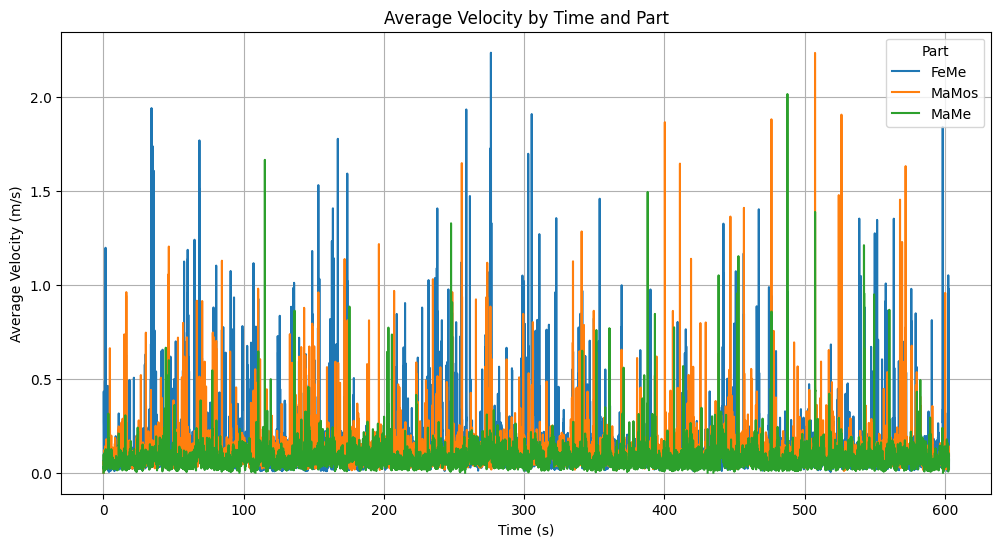

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
label = ['FeMe','MaMos','MaMe']
# Load the CSV file
file_path = 'average_velocity_by_frame_and_part.csv'
df = pd.read_csv(file_path)

# Define the frame rate (frames per second)
frame_rate = 30  # Replace this with your actual frame rate

# Convert frame numbers to time in seconds
df['Time (s)'] = df['Frame'] / frame_rate

# Create a line plot for each part
plt.figure(figsize=(12, 6))

# Loop through each part and plot
for part in df['part'].unique():
    subset = df[df['part'] == part]
    plt.plot(subset['Time (s)'], subset['average_velocity_m/s'], label=label[part])

# Adding labels and title
plt.xlabel('Time (s)')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity by Time and Part')
plt.legend(title='Part')
plt.grid(True)

# Display the plot
plt.show()


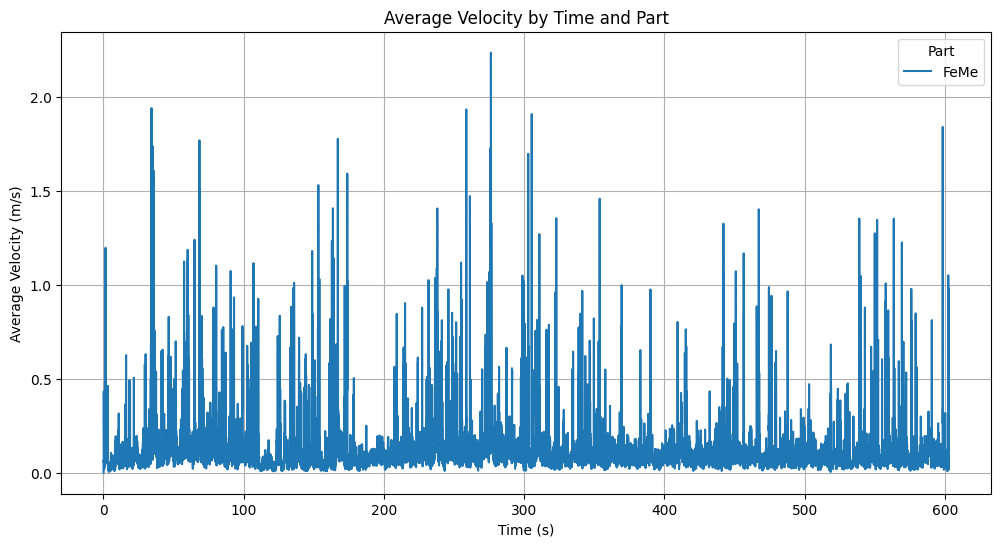

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
label = ['FeMe','MaMos','MaMe']
# Load the CSV file
file_path = 'average_velocity_by_frame_and_part.csv'
df = pd.read_csv(file_path)

# Define the frame rate (frames per second)
frame_rate = 30  # Replace this with your actual frame rate

# Convert frame numbers to time in seconds
df['Time (s)'] = df['Frame'] / frame_rate

# Create a line plot for each part
plt.figure(figsize=(12, 6))

subset = df[df['part'] == 0]

plt.plot(subset['Time (s)'], subset['average_velocity_m/s'], label='FeMe')
 

# Adding labels and title
plt.xlabel('Time (s)')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity by Time and Part')
plt.legend(title='Part')
plt.grid(True)

# Display the plot
plt.show()


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'average_velocity_by_frame_and_part.csv'
df = pd.read_csv(file_path)

# Define the frame rate (frames per second)
frame_rate = 30  # Replace this with your actual frame rate

# Convert frame numbers to time in seconds
df['Time (s)'] = df['Frame'] / frame_rate

# Create a plot for each part
for part in df['part'].unique():
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current part
    part_data = df[df['part'] == part]
    
    # Plot each object ID within the part
    for object_id in part_data['Object ID'].unique():
        object_data = part_data[part_data['Object ID'] == object_id]
        plt.plot(object_data['Time (s)'], object_data['average_velocity_m/s'], label=f'Object ID {object_id}')
    
    # Adding labels, title, and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Average Velocity (m/s)')
    plt.title(f'Average Velocity by Time for Part {part}')
    plt.legend(title='Object ID')
    plt.grid(True)
    
    # Show the plot
    plt.show()


KeyError: 'Object ID'

<Figure size 1200x600 with 0 Axes>

In [ ]:
Max 2187.821137086658,384.17940096648874

In [19]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Conversion factor from px/s to m/s (replace with the correct value)
px_to_m = 0.001  # Example: 1 pixel = 0.001 meters

# Convert the 'Velocity (px/s)' column from px/s to m/s
df['Velocity (m/s)'] = df['Velocity (px/s)'] * px_to_m

# Calculate the average velocity for each object in m/s
average_velocity = df.groupby('Object ID')['Velocity (m/s)'].mean().reset_index()

# Rename the average velocity column for clarity
average_velocity.rename(columns={'Velocity (m/s)': 'Velocity (m/s)_avg'}, inplace=True)

# Add 'part' information to the average_velocity DataFrame
# We need to merge 'df' to get 'part' information for each 'Object ID'
average_velocity_with_part = df[['Object ID', 'part']].drop_duplicates().merge(
    average_velocity, 
    on='Object ID', 
    how='right'
)

# Calculate the average of the average velocities for each part
average_velocity_per_part = df.groupby('part')['Velocity (m/s)'].mean().reset_index()

# Rename columns for clarity
average_velocity_per_part.columns = ['part', 'average_velocity_m/s']

# Save the result to a CSV file
output_path = 'average_velocity_per_part.csv'
average_velocity_per_part.to_csv(output_path, index=False)

output_path


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\3791617011.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_per_part = df.groupby('part')['Velocity (m/s)'].mean().reset_index()


'average_velocity_per_part.csv'

In [20]:
df1 = pd.read_csv('average_of_average_velocity_per_part.csv')
df1

part  average_of_average_velocity
0     0                   116.279833
1     1                   110.856229
2     2                    73.713038

In [8]:
part_0_data 

Object ID  part  average_velocity
0             1     0         26.816274
2             2     0        114.824832
4             4     0        113.964640
8             9     0        194.566857
10           11     0        100.389944
...         ...   ...               ...
1402       3866     0         58.813781
1406       3875     0         40.099814
1409       3882     0        158.485724
1410       3886     0         48.699393
1412       3892     0         83.211987

[605 rows x 3 columns]

In [18]:
df1[df1['part'] == 0]['Velocity (m/s)_avg'].mean()

0.11627983296296156

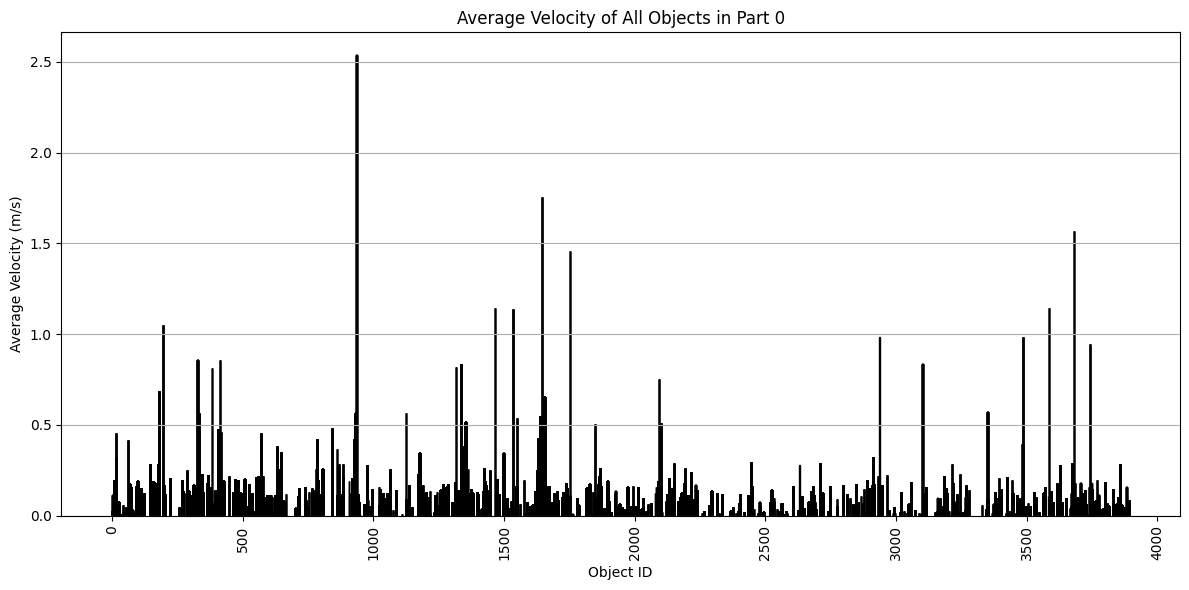

In [29]:
part_0_data = df1[df1['part'] == 0]

# Plotting the bar plot of average velocities for objects in Part 0
plt.figure(figsize=(12, 6))
plt.bar(part_0_data['Object ID'], part_0_data['Velocity (m/s)_avg'], color='teal', edgecolor='black')
plt.xlabel('Object ID')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity of All Objects in Part 0')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('average_velocity_part_0_bar_plot.png')
plt.show()

In [30]:
average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\2196069979.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()


KeyError: 'Column not found: Velocity (m/s)_avg'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 0]

# Calculate the mean of average velocities for Part 0
mean_velocity_part_0 = part_0_data['average_velocity'].mean()*0.001

# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(df1[df1['part'] == 0]['Velocity (m/s)_avg'], bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_velocity_part_0, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities FeMe')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('histogram_average_velocity_part_0_with_mean.png')
plt.show()


(array([       1671,       11349,        8600,        7747,       13625,        8731,        9656,        3194,        1021,         540,         507,         368,          90,         156,          58,          26,          99,          31,          45,          27,          53,          48,          55,           0,
                  0,          29,          23,           0,           0,           7,           0,           5,          55,          17,           0,           0,           0,           9,          12,           0,           0,          11,           0,           0,          12,          12,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           6,           0,           0,           0,           6,           0,           0,           0,           0,           0,           0,           0,           9,           0,           0,
                  0,           0,       

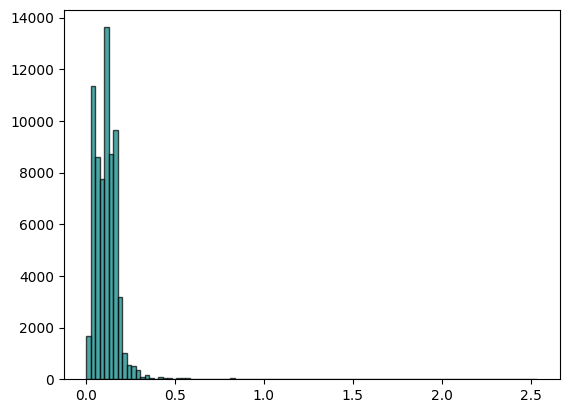

In [82]:
plt.hist(, bins=100, color='teal', edgecolor='black', alpha=0.7)


In [94]:
df1

Frame  Object ID     X Center     Y Center  Velocity (px/s)  part  \
0           3.0          1   985.757581   412.531001         0.000000     0   
1           3.0          2  1147.786982   700.017559         0.000000     1   
2           3.0          3  1712.668620   464.779109         0.000000     1   
3           3.0          4  1061.017748   667.362990         0.000000     0   
4           3.0          5  1644.126933   718.161430         0.000000     1   
...         ...        ...          ...          ...              ...   ...   
203869  18090.0       3881  1289.135880  1075.748135        65.638723     1   
203870  18090.0       3887  1813.568151   359.366298        47.106075     2   
203871  18090.0       3892  1050.726368   851.547256         5.327850     0   
203872  18090.0       3893  2283.407856   771.872444       152.969080     2   
203873  18090.0       3894  1242.460895  1019.585683       175.720507     1   

        Velocity (m/s)  Velocity (m/s)_avg  
0             0.000000            0.026816  
1             0.000000            0.114825  
2             0.000000            0.051660  
3             0.000000            0.113965  
4             0.000000            0.129423  
...                ...                 ...  
203869        0.065639            0.018435  
203870        0.047106            0.040233  
203871        0.005328            0.083212  
203872        0.152969            0.126048  
203873        0.175721            0.133598  

[203874 rows x 8 columns]

In [70]:
df1 = pd.read_csv('average_velocity_with_part.csv')
df1

Frame  Object ID     X Center     Y Center  Velocity (px/s)  part  \
0           3.0          1   985.757581   412.531001         0.000000     0   
1           3.0          2  1147.786982   700.017559         0.000000     1   
2           3.0          3  1712.668620   464.779109         0.000000     1   
3           3.0          4  1061.017748   667.362990         0.000000     0   
4           3.0          5  1644.126933   718.161430         0.000000     1   
...         ...        ...          ...          ...              ...   ...   
203869  18090.0       3881  1289.135880  1075.748135        65.638723     1   
203870  18090.0       3887  1813.568151   359.366298        47.106075     2   
203871  18090.0       3892  1050.726368   851.547256         5.327850     0   
203872  18090.0       3893  2283.407856   771.872444       152.969080     2   
203873  18090.0       3894  1242.460895  1019.585683       175.720507     1   

        Velocity (m/s)  Velocity (m/s)_avg  
0             0.000000            0.026816  
1             0.000000            0.114825  
2             0.000000            0.051660  
3             0.000000            0.113965  
4             0.000000            0.129423  
...                ...                 ...  
203869        0.065639            0.018435  
203870        0.047106            0.040233  
203871        0.005328            0.083212  
203872        0.152969            0.126048  
203873        0.175721            0.133598  

[203874 rows x 8 columns]

In [83]:
# Step 1: Filter the DataFrame where 'part' is 2 and 'Velocity (m/s)' is 0
df = df1[(df1['part'] == 0)]

# Step 2: Remove rows where 'Velocity (m/s)' is 0 if 'Frame' is not 3
df = df[~((df['Frame'] != 3) & (df['Velocity (m/s)'] == 0))]

df2 = df[(df['Velocity (m/s)'] == 0)]
df1

Frame  Object ID     X Center     Y Center  Velocity (px/s)  part  \
0           3.0          1   985.757581   412.531001         0.000000     0   
1           3.0          2  1147.786982   700.017559         0.000000     1   
2           3.0          3  1712.668620   464.779109         0.000000     1   
3           3.0          4  1061.017748   667.362990         0.000000     0   
4           3.0          5  1644.126933   718.161430         0.000000     1   
...         ...        ...          ...          ...              ...   ...   
203869  18090.0       3881  1289.135880  1075.748135        65.638723     1   
203870  18090.0       3887  1813.568151   359.366298        47.106075     2   
203871  18090.0       3892  1050.726368   851.547256         5.327850     0   
203872  18090.0       3893  2283.407856   771.872444       152.969080     2   
203873  18090.0       3894  1242.460895  1019.585683       175.720507     1   

        Velocity (m/s)  Velocity (m/s)_avg  
0             0.000000            0.026816  
1             0.000000            0.114825  
2             0.000000            0.051660  
3             0.000000            0.113965  
4             0.000000            0.129423  
...                ...                 ...  
203869        0.065639            0.018435  
203870        0.047106            0.040233  
203871        0.005328            0.083212  
203872        0.152969            0.126048  
203873        0.175721            0.133598  

[203874 rows x 8 columns]

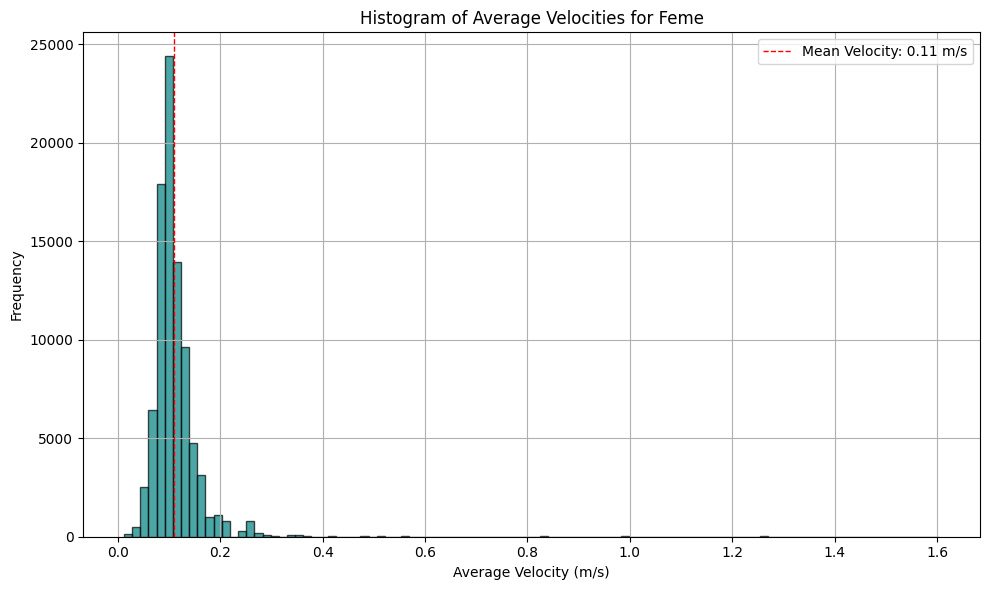

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 1]
# part_0_data = df

mean_velocity_part_0 = part_0_data['Velocity (m/s)_avg'].mean()

# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['Velocity (m/s)_avg'], bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_velocity_part_0, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Feme')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Test_mean.png')
plt.show()


In [99]:
import pandas as pd
import numpy as np

# Load your DataFrame (assuming you've already read the data into `df`)
df = pd.read_csv('average_velocity_with_part.csv')

# Function to calculate distance between consecutive points
def calculate_distance(group):
    group = group.sort_values('Frame')
    x_diff = group['X Center'].diff()
    y_diff = group['Y Center'].diff()
    
    # Set distance to 0 where both x_diff and y_diff are NaN
    group['Distance'] = np.where(pd.isna(x_diff) & pd.isna(y_diff), 0, np.sqrt(x_diff**2 + y_diff**2) * 0.001)
    
    return group

# Apply the function to calculate distance for each Object ID group
df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)

# Calculate the total distance for each Object ID and part
total_distances = df.groupby(['Object ID', 'part'])['Distance'].sum().reset_index()

# Rename the column for clarity
total_distances.rename(columns={'Distance': 'Total Distance (m)'}, inplace=True)

# Show the result
total_distances


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\3464088341.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)


Object ID  part  Total Distance (m)
0             1     0            0.736395
1             2     0            0.088402
2             2     1            0.283236
3             3     1            0.113766
4             4     0            0.285197
...         ...   ...                 ...
1410       3886     0            0.012999
1411       3887     2            0.053697
1412       3892     0            0.055530
1413       3893     2            0.067293
1414       3894     1            0.040120

[1415 rows x 3 columns]

In [106]:
part_0_data = total_distances[total_distances['part'] == 0]
part_0_data

Object ID  part  Distance
0             1     0  0.736395
1             2     0  0.088402
4             4     0  0.285197
8             9     0  0.389523
10           11     0  1.125492
...         ...   ...       ...
1402       3866     0  0.257077
1406       3875     0  0.125772
1408       3882     0  0.291938
1410       3886     0  0.012999
1412       3892     0  0.055530

[605 rows x 3 columns]

In [115]:
part_1_data = total_distances[total_distances['part'] == 0]
part_1_data['Distance'].mean()

0.4393946098852962

In [116]:
part_1_data['Distance']

0       0.736395
1       0.088402
4       0.285197
8       0.389523
10      1.125492
          ...   
1402    0.257077
1406    0.125772
1408    0.291938
1410    0.012999
1412    0.055530
Name: Distance, Length: 605, dtype: float64

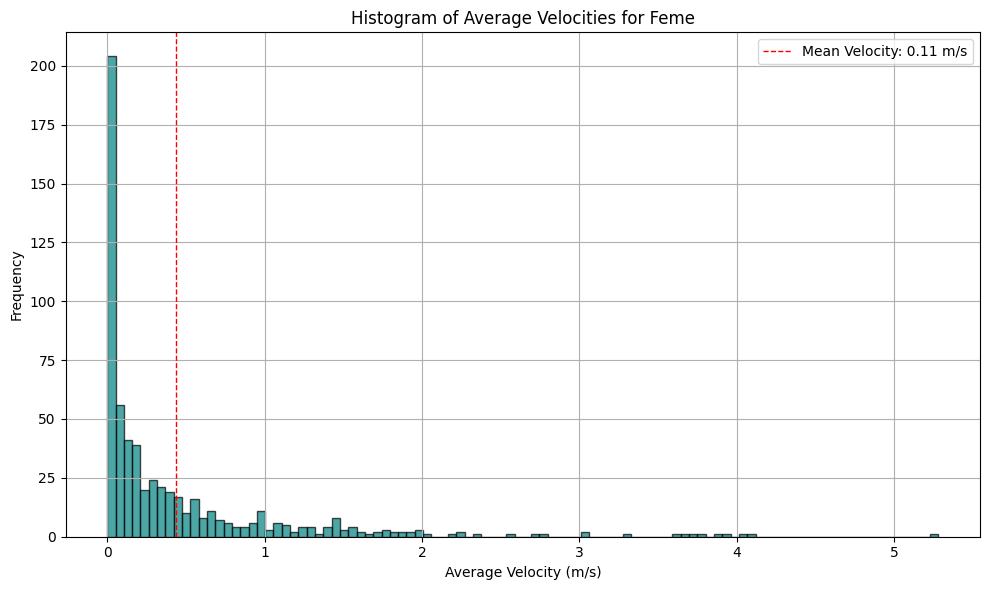

In [113]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['Distance'], bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(part_0_data['Distance'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Feme')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Test_Distance.png')
plt.show()


In [ ]:
total1 = df[]

In [ ]:
df['Distance'][]

In [93]:
a = df['X Center'].diff()
a


0                 NaN
1          162.029401
2          564.881638
3         -651.650872
4          583.109184
             ...     
203869     243.823761
203870     524.432271
203871    -762.841783
203872    1232.681488
203873   -1040.946961
Name: X Center, Length: 203874, dtype: float64

Frame  Object ID     X Center     Y Center  Velocity (px/s)  part  \
4       3.0          5  1644.126933   718.161430         0.000000     1   
15      4.0          5  1644.413080   717.531669        20.730924     1   
26      5.0          5  1644.686720   716.119069        43.122659     1   
38      6.0          5  1644.977849   715.344186        24.808249     1   
50      7.0          5  1645.509130   715.005120        18.888827     1   
...     ...        ...          ...          ...              ...   ...   
8051  721.0          5  1215.675535  1313.221915        79.705715     1   
8061  722.0          5  1217.954219  1314.593270        79.705715     1   
8071  723.0          5  1220.232903  1315.964625        79.705715     1   
8081  724.0          5  1222.511587  1317.335980        79.705715     1   
8092  725.0          5  1224.790271  1318.707335        79.705715     1   

      Velocity (m/s)  Velocity (m/s)_avg  Distance  
4           0.000000            0.129423       NaN  
15          0.020731            0.129423  0.000692  
26          0.043123            0.129423  0.001439  
38          0.024808            0.129423  0.000828  
50          0.018889            0.129423  0.000630  
...              ...                 ...       ...  
8051        0.079706            0.129423  0.002660  
8061        0.079706            0.129423  0.002660  
8071        0.079706            0.129423  0.002660  
8081        0.079706            0.129423  0.002660  
8092        0.079706            0.129423  0.002660  

[723 rows x 9 columns]

In [23]:
import pandas as pd

# Load the original CSV with average velocities of each object
average_velocity_path = 'average_velocity_per_object.csv'
average_velocity = pd.read_csv(average_velocity_path)

# Load the original CSV with the full data to get the 'part' information
full_data_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
full_data = pd.read_csv(full_data_path)

# Ensure the 'part' column exists in the full_data DataFrame
# If 'part' is not in full_data, recalculate it using the thresholds
if 'part' not in full_data.columns:
    x_threshold_1 = 1095.7869824778165
    x_threshold_2 = 1770.7869824778165
    full_data['part'] = pd.cut(full_data['X Center'], 
                               bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                               labels=[0, 1, 2])

# Merge the average velocity DataFrame with the 'part' information
average_velocity_with_part = full_data[['Object ID', 'part']].drop_duplicates().merge(
    average_velocity, 
    on='Object ID', 
    how='right'
)

# Save the updated DataFrame with the 'part' column to a new CSV file
updated_average_velocity_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part.to_csv(updated_average_velocity_path, index=False)

updated_average_velocity_path


'average_velocity_per_object_with_part.csv'

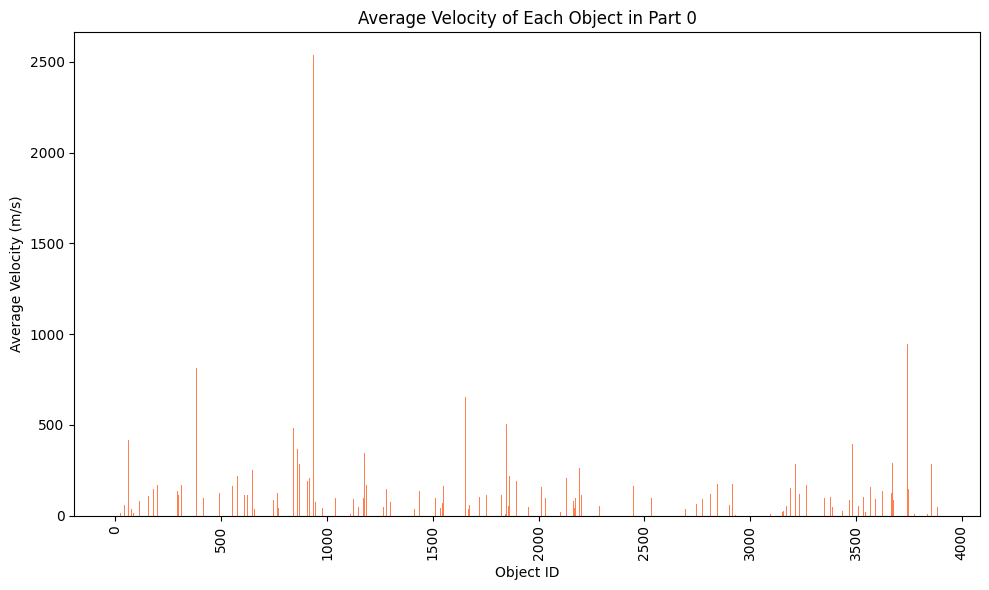

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 0]

# Plotting the average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.bar(part_0_data['Object ID'], part_0_data['average_velocity'], color='coral')
plt.xlabel('Object ID')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity of Each Object in Part 0')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('average_velocity_part_0.png')
plt.show()


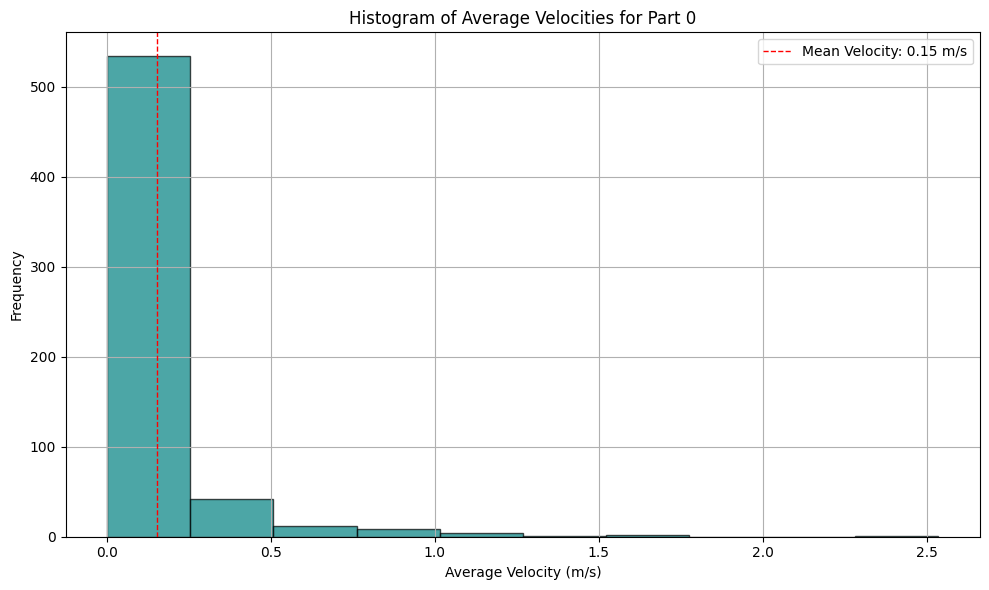

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 0]

# Calculate the mean of average velocities for Part 0
mean_velocity_part_0 = part_0_data['average_velocity'].mean()*0.001

# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['average_velocity']*0.001, bins=10, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_velocity_part_0, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Part 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('histogram_average_velocity_part_0_with_mean.png')
plt.show()


In [59]:
part_0_data['average_velocity']

0        26.816274
2       114.824832
4       113.964640
8       194.566857
10      100.389944
           ...    
1402     58.813781
1406     40.099814
1409    158.485724
1410     48.699393
1412     83.211987
Name: average_velocity, Length: 605, dtype: float64

KeyError: 'Object ID'

In [38]:
hist(part_0_data['average_velocity'])